In [1]:
import pandas as pd
import numpy as np
from orix import io
import kikuchipy as kp
import ast
from data_preprocessing import get_eds_average, fit_preprocessors, apply_preprocessors, coord_xmap_dict, load_and_merge_csvs, coord_phase_dict_from_dataframe, load_and_merge_by_coords
from sklearn.model_selection import train_test_split
from eds_element_dr import analyze_elements_clustering, run_element_pca, plot_explained_variance,gmm_clustering,plot_cluster_heatmap, prepare_elements_matrix
from contrastivemodel import train_and_evaluate, evaluate_contrastive
from visualize_contrastive import visualize_loss_curve, visualize_contrastive_embeddings, visualize_contrastive_embeddings_by_element, visualize_contrastive_embeddings_by_phase

In [2]:
roi_xrange = (250,300)
roi_yrange = (30,70)

In [3]:
element_f = "../micro_segmentation/20min_element_maps.csv"
df_element = pd.read_csv(element_f)

In [4]:
df_coords = df_element[['x','y']]

### 1.1 Element Data Dimesionality Reduction

In [5]:
df_element

x    y        Al          C  ...         S        Si        Ti         V
0         0    0  0.667018   0.000000  ...  0.000000  0.000000  0.000000  0.750276
1         1    0  0.000000   0.000000  ...  0.000000  0.536241  0.336721  2.243156
2         2    0  0.169651   0.000000  ...  0.000000  0.000000  0.000000  0.888515
3         3    0  0.000000   3.963396  ...  0.000000  0.855272  0.438452  0.000000
4         4    0  0.516937   7.449079  ...  0.000000  1.691627  0.000000  0.108088
...     ...  ...       ...        ...  ...       ...       ...       ...       ...
196603  507  383  0.353181   0.000000  ...  0.000000  0.241579  0.222975  0.000000
196604  508  383  0.511425   6.006280  ...  0.917461  1.379161  0.000000  0.000000
196605  509  383  0.312744   9.624764  ...  0.173003  3.053374  0.000000  1.561092
196606  510  383  0.000000  14.714010  ...  0.000000  1.842943  0.654208  0.000000
196607  511  383  0.000000   6.390316  ...  0.000000  2.394486  0.000000  0.630427

[196608 rows x 16 columns]

In [5]:
element_cols = ['Al', 'C', 'Ca', 'Fe', 'K', 'Mg', 'Na', 'O', 'P','S', 'Si', 'Ti', 'V']

/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[KMeans] best_k=2, silhouette=0.16881205235059896
[DBSCAN] clusters=0, noise=2000


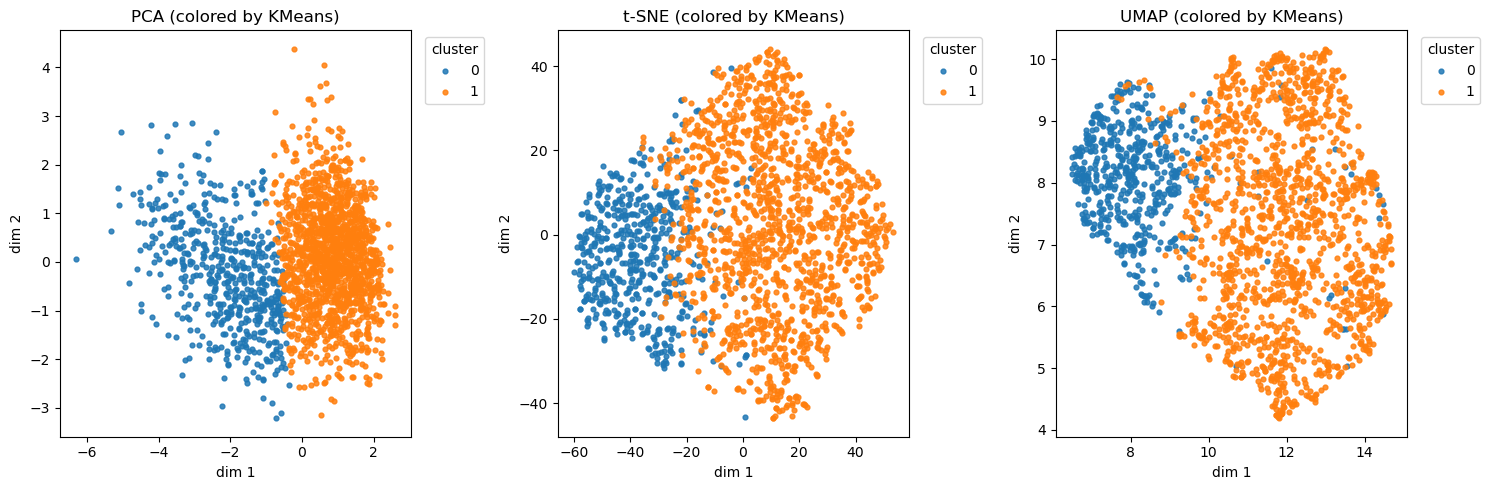

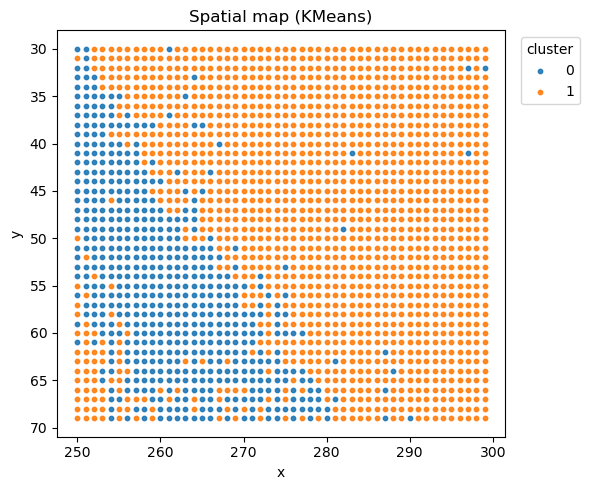

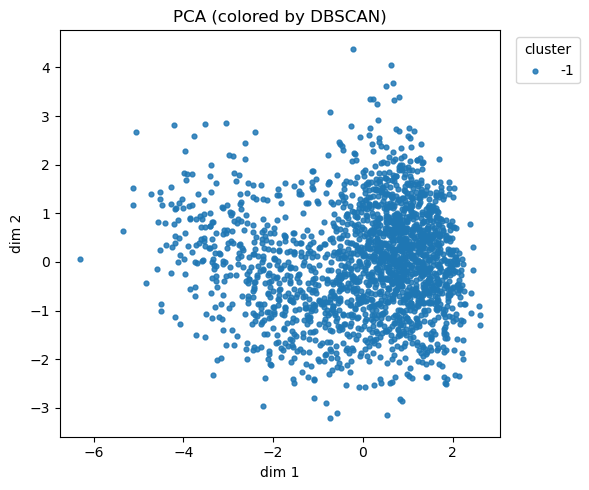

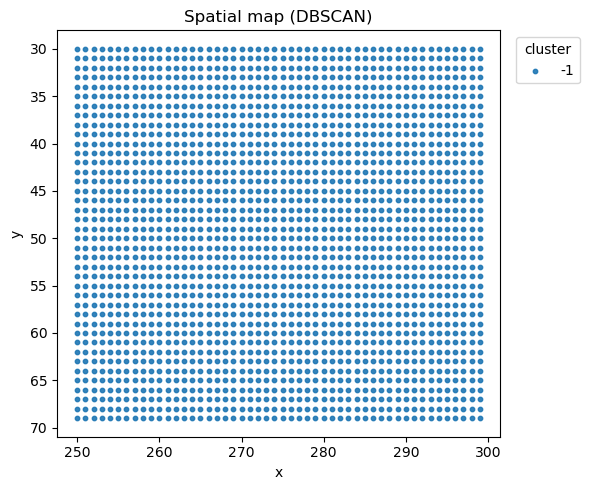

In [ ]:

# element_cols = [ 'Al','Ca','Fe', 'K', 'Mg', 'Na','O', 'P','S', 'Si', 'Ti', 'V']
results = analyze_elements_clustering(
    df_element,
    element_cols=element_cols,
    x_col="x", y_col="y",
    roi_xrange=roi_xrange, roi_yrange=roi_yrange,
    kmin=2, kmax=8,                # search K
    use_umap=True,                 # set False if you don’t want/ have UMAP
    try_dbscan_flag=True,          # also try DBSCAN
    dbscan_eps=0.1, dbscan_min_samples=10
)

In [6]:
X_std, X_raw, scaler = prepare_elements_matrix(df_element, element_cols, normalize_rows=True, standardize=True)
loc_roi = df_coords.to_numpy()
gmm, cluster_coords, coord_to_label, labels, kstar, sil = gmm_clustering(
    scores=X_std,
    loc_roi=loc_roi,
    n_components=None,
    max_components=10
    )

plot_cluster_heatmap(cluster_coords, img_shape=(50,40))

KeyboardInterrupt: 

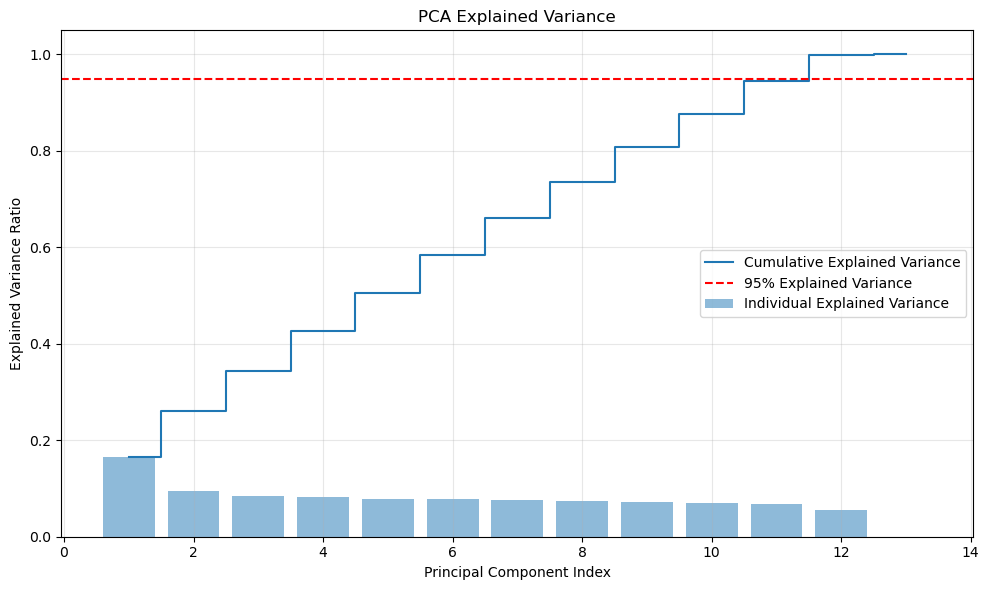

In [ ]:
pca_scores, pca_loadings, exp_var, pca_model = run_element_pca(df_element, element_cols, n_components=13)

plot_explained_variance(pca_model)

In [13]:
# PCA dataframe
D = pca_scores.shape[1]
pca_element_cols = [f"PCA_{i+1}" for i in range(D)]
pca_element_df = pd.DataFrame(
    np.column_stack([df_coords, pca_scores]),
    columns=["x", "y"] + pca_element_cols)


pca_element_df.to_csv("20min_eds_pca_scores.csv", index=False)

In [6]:
pca_f = "../micro_segmentation/20min_pca_scores.csv"
cnmf_f = "../micro_segmentation/20min_cnmf_weights.csv"
# element_f = "20min_eds_pca_scores.csv"
element_f = "../micro_segmentation/20min_element_maps.csv"
df_all, df_coords = load_and_merge_csvs(pca_f, cnmf_f, element_f, roi_xrange=roi_xrange, roi_yrange=roi_yrange, x_col="x", y_col="y", phase_labels=(0,1), phase_col="phase_label")

### 1.2 Select the Iron-1 and Magnetite samples

In [7]:
df_p = pd.read_csv("../micro_segmentation/ebsd_processed_with_grain_boundary.csv")
coord_phase_dict = coord_phase_dict_from_dataframe(df_p)

In [8]:
element_cols = ['Al', 'C', 'Ca', 'Fe', 'K', 'Mg', 'Na', 'O', 'P','S', 'Si', 'Ti', 'V']

In [22]:
train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=42, shuffle=True)

loc_train = df_coords.loc[train_df.index]
loc_test  = df_coords.loc[test_df.index]

transformers = fit_preprocessors(
    train_df,
    pca_scale='standard',     
    cnmf_transform='clr',     
    elem_transform='raw' 
)

train_data = apply_preprocessors(train_df, transformers)
test_data  = apply_preprocessors(test_df, transformers)

In [23]:
feature_pc_cols = [c for c in test_data.columns if 'PCA_' in c]
feature_cnmf_cols = [c for c in test_data.columns if 'cNMF_' in c]
# element_cols = ['Al', 'C', 'Ca', 'Fe', 'K', 'Mg', 'Na', 'O', 'P','S', 'Si', 'Ti', 'V']


features_pc_np = test_data[feature_pc_cols].values.astype(np.float32)
features_cnmf_np = test_data[feature_cnmf_cols].values.astype(np.float32)
elements_np = test_data[element_cols].values.astype(np.float32)

In [33]:
# Train the model
print("Training PCA Model...")
pca_model, pca_train_losses, pca_test_losses, final_alignment_pca, final_uniformity_pca = train_and_evaluate(
    'pca', train_data, test_data, output_dim=1024, latent_dim=2048, num_epochs=100, batch_size=128, lr=3e-4,temperature=1,learnable_temp=True, min_temp=0.01, max_temp=2, temp_anneal=False
)

Training PCA Model...
Epoch 1: Alignment=1.9309, Uniformity=-1.2607 | ||zf||=1.000 ||ze||=1.000
Epoch [1/100], PCA - Train Loss: 4.7507, Test Loss: 4.4841, Temp: 1.0000
Epoch [2/100], PCA - Train Loss: 4.7175, Test Loss: 4.3837, Temp: 0.9984
Epoch [3/100], PCA - Train Loss: 4.6426, Test Loss: 4.2731, Temp: 0.9968
Epoch [4/100], PCA - Train Loss: 4.5720, Test Loss: 4.2214, Temp: 0.9950
Epoch [5/100], PCA - Train Loss: 4.5059, Test Loss: 4.1602, Temp: 0.9928
Epoch [6/100], PCA - Train Loss: 4.4540, Test Loss: 4.1497, Temp: 0.9906
Epoch [7/100], PCA - Train Loss: 4.4261, Test Loss: 4.0819, Temp: 0.9884
Epoch [8/100], PCA - Train Loss: 4.4052, Test Loss: 4.0910, Temp: 0.9864
Epoch [9/100], PCA - Train Loss: 4.3923, Test Loss: 4.0893, Temp: 0.9852
Epoch [10/100], PCA - Train Loss: 4.3790, Test Loss: 4.0592, Temp: 0.9848
Epoch 11: Alignment=0.4073, Uniformity=-1.0986 | ||zf||=1.000 ||ze||=1.000
Epoch [11/100], PCA - Train Loss: 4.3614, Test Loss: 4.0389, Temp: 0.9846
Epoch [12/100], PCA - Tr

In [27]:
print("\nTraining cNMF Model...")
cnmf_model, cnmf_train_losses, cnmf_test_losses, final_alignment_cnmf, final_uniformity_cnmf = train_and_evaluate(
    'cnmf', train_data, test_data, output_dim=32,latent_dim=128,num_epochs=100, batch_size=64, lr=1e-3, temperature=1,learnable_temp=True, min_temp=0.01, max_temp=2, temp_anneal=False
)


Training cNMF Model...
Epoch 1: Alignment=1.5716, Uniformity=-1.3508 | ||zf||=1.000 ||ze||=1.000
Epoch [1/100], CNMF - Train Loss: 4.1083, Test Loss: 4.0039, Temp: 1.0000
Epoch [2/100], CNMF - Train Loss: 4.0558, Test Loss: 3.9721, Temp: 0.9967
Epoch [3/100], CNMF - Train Loss: 3.9728, Test Loss: 3.9371, Temp: 0.9887
Epoch [4/100], CNMF - Train Loss: 3.8231, Test Loss: 3.8618, Temp: 0.9682
Epoch [5/100], CNMF - Train Loss: 3.7310, Test Loss: 3.8337, Temp: 0.9388
Epoch [6/100], CNMF - Train Loss: 3.6291, Test Loss: 3.8475, Temp: 0.9090
Epoch [7/100], CNMF - Train Loss: 3.5250, Test Loss: 3.8282, Temp: 0.8808
Epoch [8/100], CNMF - Train Loss: 3.4571, Test Loss: 3.8876, Temp: 0.8532
Epoch [9/100], CNMF - Train Loss: 3.3866, Test Loss: 3.8578, Temp: 0.8267
Epoch [10/100], CNMF - Train Loss: 3.3130, Test Loss: 3.8877, Temp: 0.8018
Epoch 11: Alignment=0.6626, Uniformity=-1.2051 | ||zf||=1.000 ||ze||=1.000
Epoch [11/100], CNMF - Train Loss: 3.2654, Test Loss: 3.8457, Temp: 0.7777
Epoch [12/1

[eval] features zf: shape=(300, 1024), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.027111, pairwise-dist(mean)=1.199969
[eval] features zf: approx unique rows (4dp) = 300
[eval] elements ze: shape=(300, 1024), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.028618, pairwise-dist(mean)=1.263442
[eval] elements ze: approx unique rows (4dp) = 300
[Retrieval] Top-1/5/10: {1: 0.016666666666666666, 5: 0.05333333333333334, 10: 0.1} | Median rank: 57.5
[Logit gap] mean/median: -0.3391017019748688 -0.17322981357574463
[Pair cosine distance] mean/std/min/max: 0.36830613017082214 0.4006531536579132 0.0037493109703063965 1.703961730003357
[W&I] Alignment=0.7366  Uniformity=-1.6241


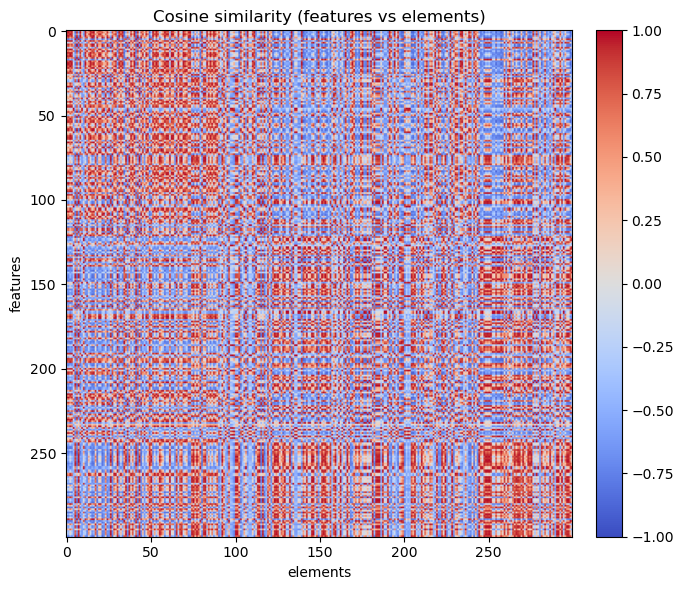

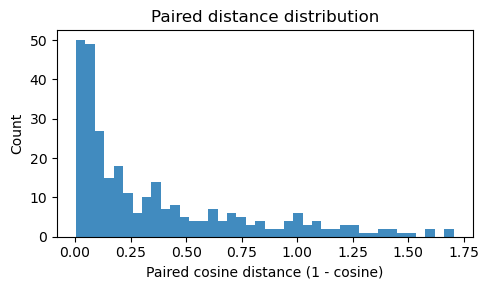

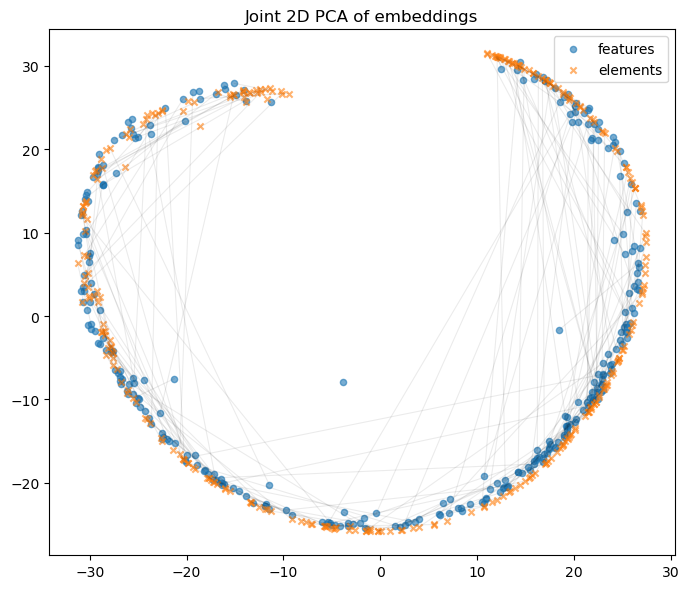

/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


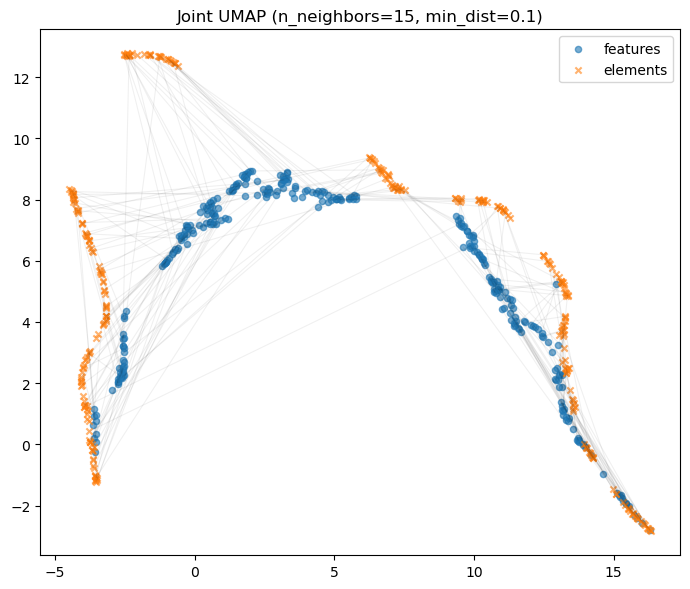

In [34]:
phase_labels = {
    -1: 'not_indexed',
     1: 'Iron bcc (old)',
     3: 'Hematite',
     4: 'Magnetite',
     5: 'Wuestite'
}
e_metrics = evaluate_contrastive(pca_model,features_pc_np,elements_np,loc_test,coord_phase_dict,phase_labels,True)

[eval] features zf: shape=(300, 32), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.050010, pairwise-dist(mean)=0.378914
[eval] features zf: approx unique rows (4dp) = 300
[eval] elements ze: shape=(300, 32), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.035649, pairwise-dist(mean)=0.273616
[eval] elements ze: approx unique rows (4dp) = 300
[Retrieval] Top-1/5/10: {1: 0.0033333333333333335, 5: 0.02666666666666667, 10: 0.043333333333333335} | Median rank: 130.5
[Logit gap] mean/median: -0.09938814491033554 -0.08178931474685669
[Pair cosine distance] mean/std/min/max: 0.18852299451828003 0.08624570071697235 0.04133385419845581 0.5241726636886597
[W&I] Alignment=0.3770  Uniformity=-0.4761


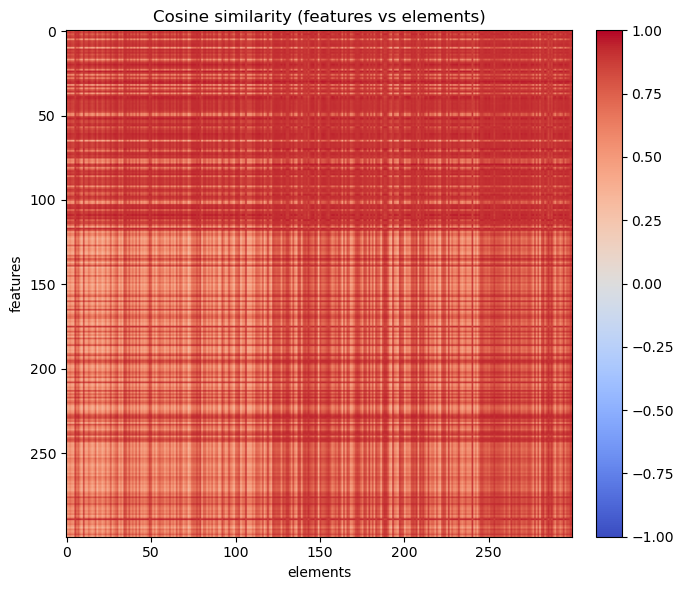

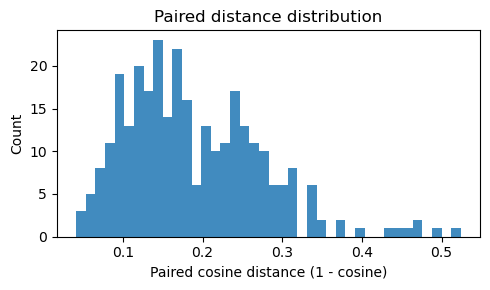

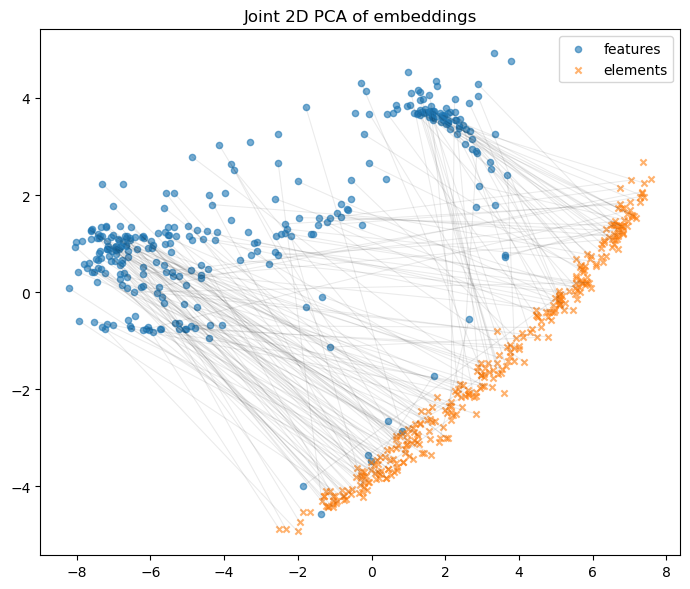

/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


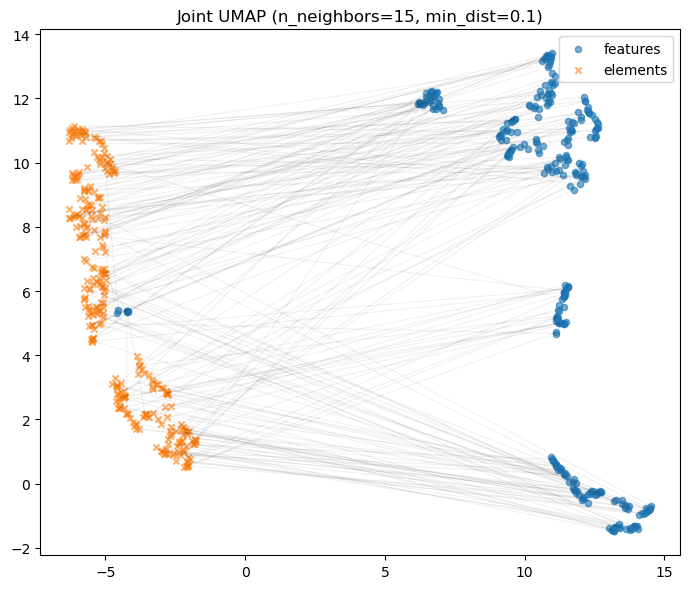

In [28]:
e_metrics = evaluate_contrastive(cnmf_model,features_cnmf_np,elements_np,loc_test,coord_phase_dict,phase_labels,True)

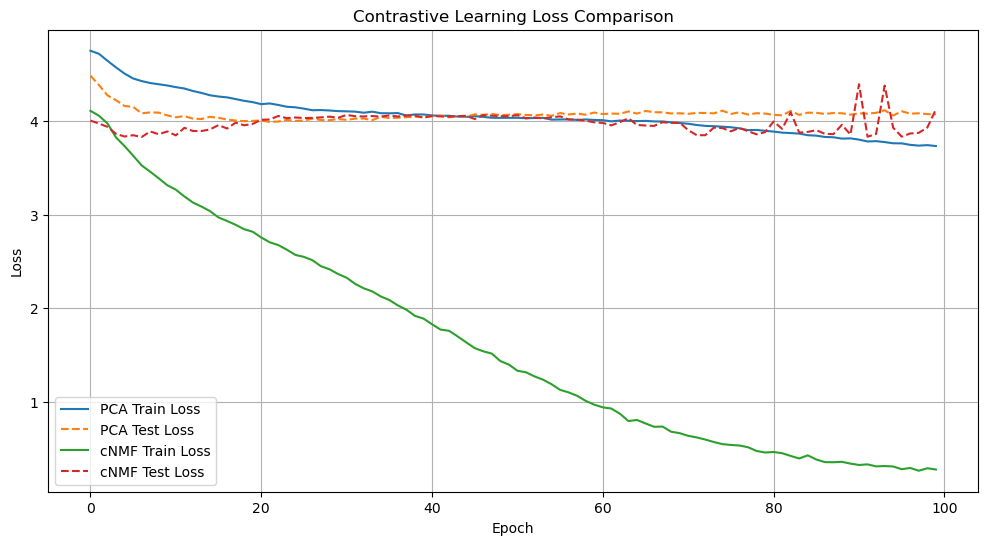

In [35]:
visualize_loss_curve(pca_model, cnmf_model, test_data, pca_train_losses, pca_test_losses, cnmf_train_losses, cnmf_test_losses)

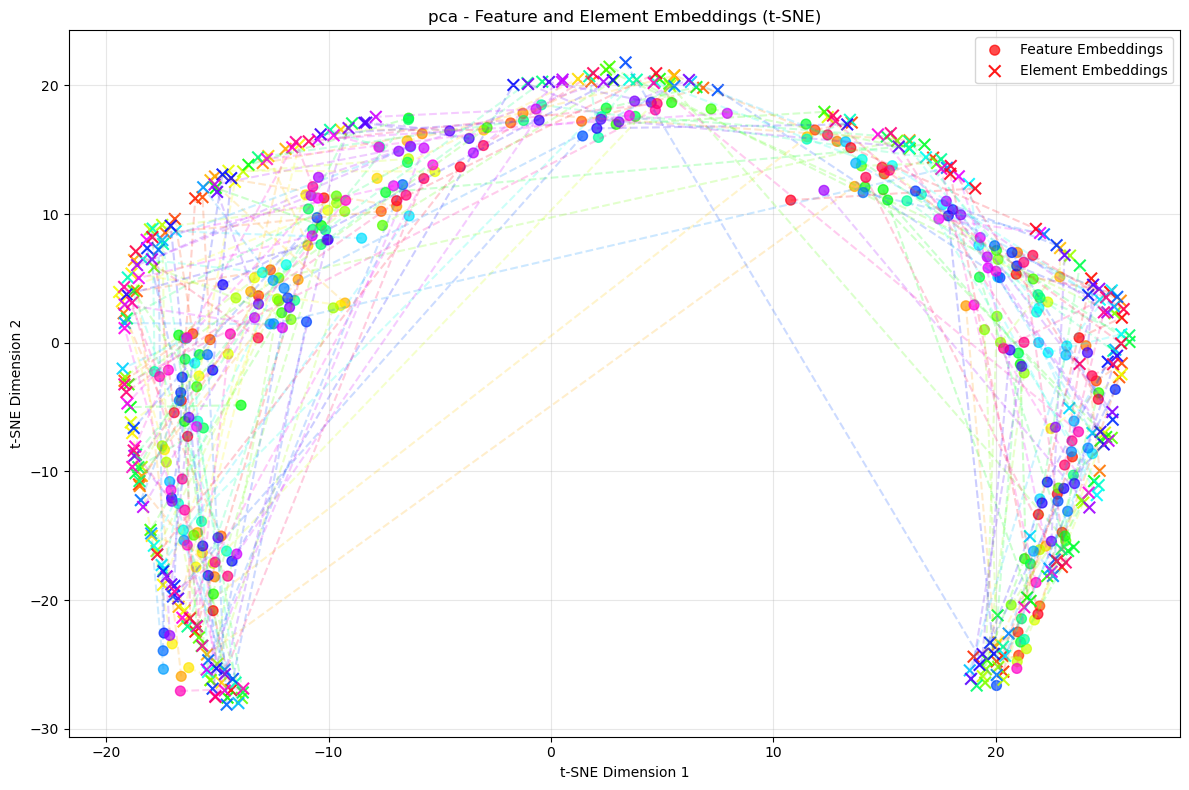

Average distance between feature and element embeddings: 14.7135


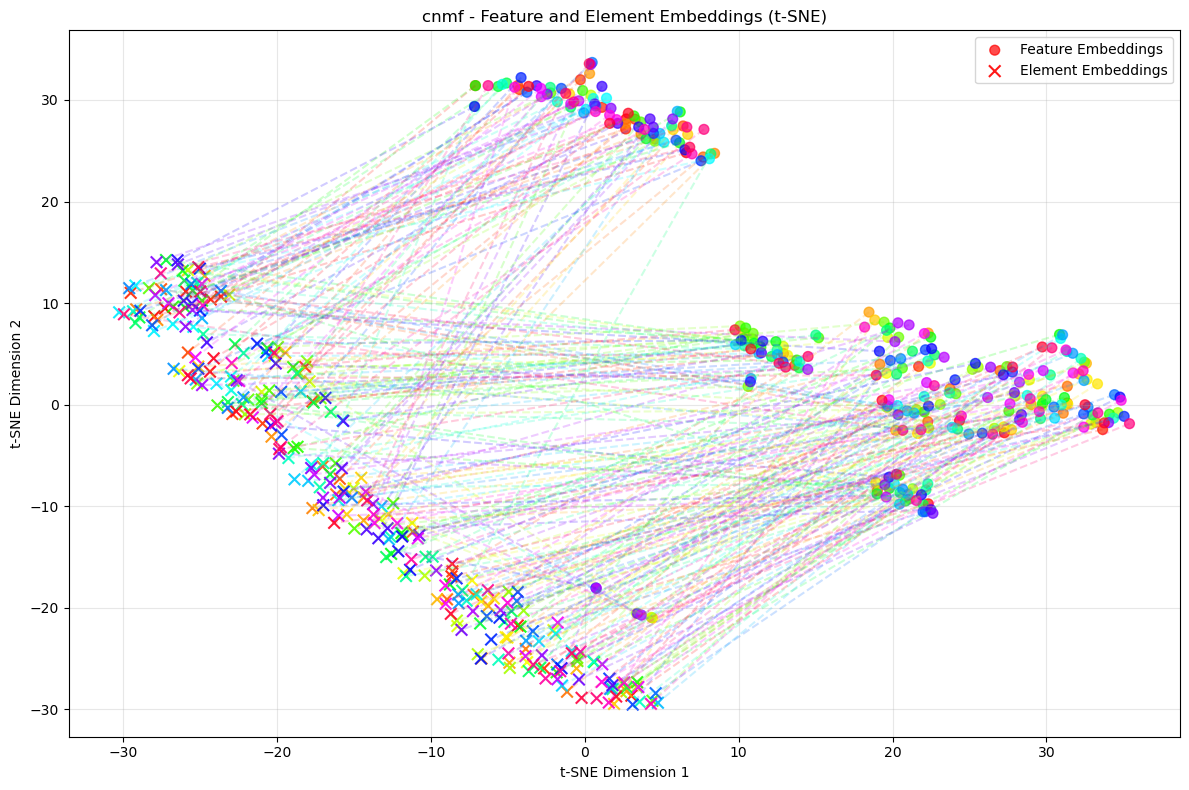

Average distance between feature and element embeddings: 37.9715


In [36]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(pca_model, test_data, 'pca', element_cols)
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(cnmf_model, test_data, 'cnmf', element_cols)

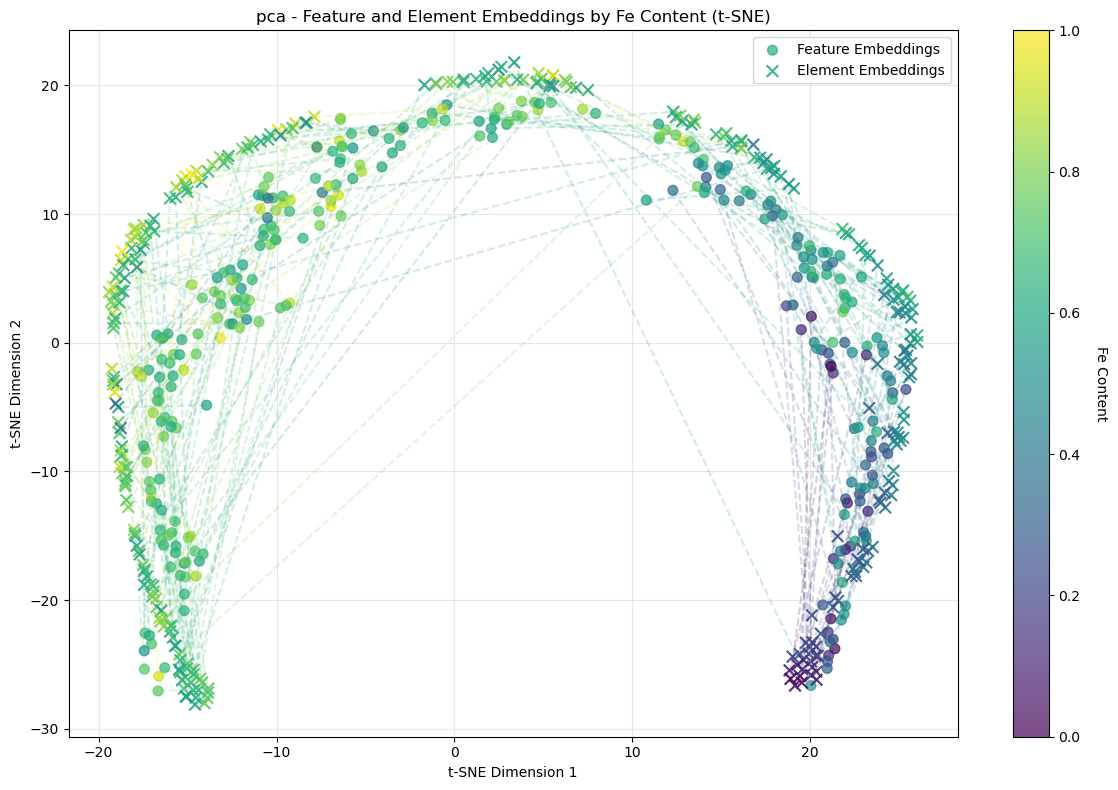

Average distance between feature and element embeddings: 14.7135
Correlation between distance and Fe content: -0.0214


In [37]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(pca_model, test_data, 'pca', 'Fe', element_cols)

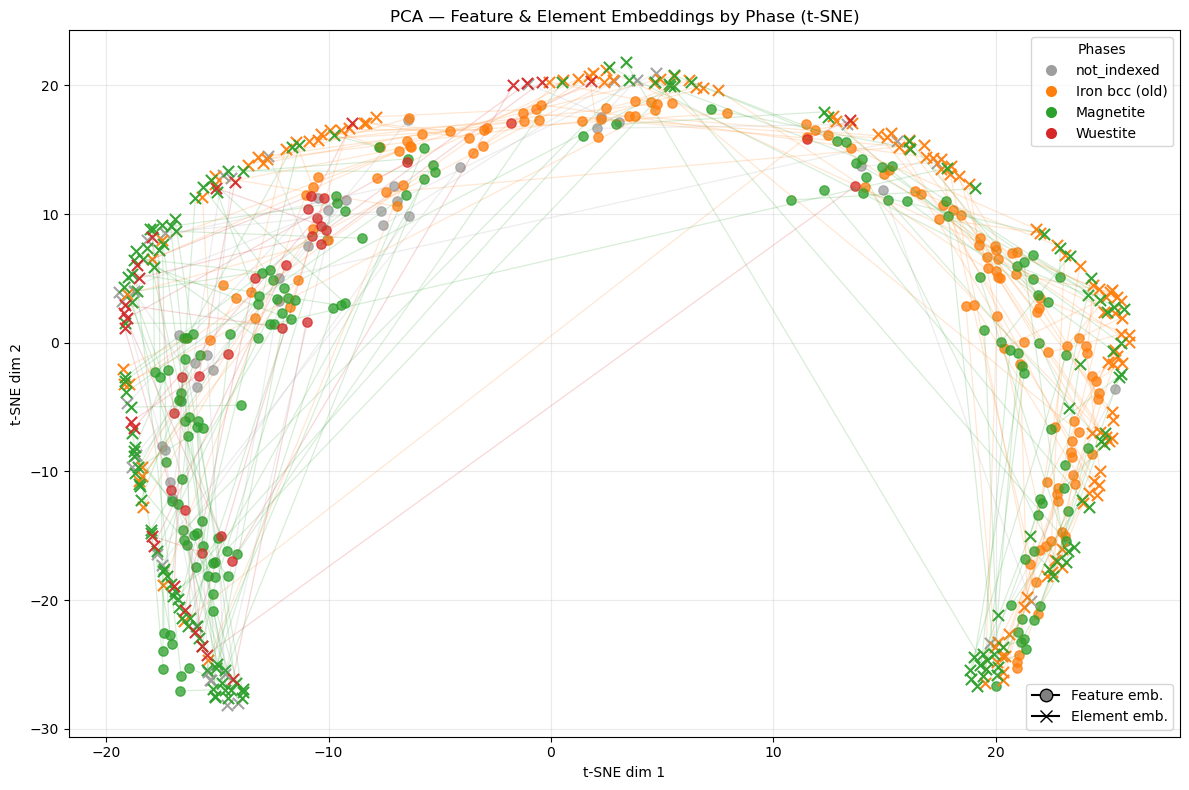

Average feature↔element t-SNE distance: 14.7135

Distance by phase:
      not_indexed: 18.6918
   Iron bcc (old): 12.7369
        Magnetite: 15.3123
         Wuestite: 16.1556


In [38]:
phase_labels = {
    -1: 'not_indexed',
     1: 'Iron bcc (old)',
     3: 'Hematite',
     4: 'Magnetite',
     5: 'Wuestite'
}
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_phase(pca_model, test_data, np.asarray(loc_test), coord_phase_dict, phase_labels, 'pca',element_cols)

### 1.2 Boundary? Points --- To do the contrastive learning
    (1) The element info varies largely on the boundary but very close to each other within one grain (no phase difference and also minor misorientation), Thus it might be reasonable to only investigate or test the feasibility only with the boundary points

In [9]:
coord_df_b = pd.read_csv("../micro_segmentation/20min_boundary_locs.csv")

In [10]:
df_all, df_coords = load_and_merge_by_coords(pca_f, cnmf_f, element_f, coord_df_b, roi_xrange=roi_xrange, roi_yrange=roi_yrange, x_col="x", y_col="y")

In [12]:
train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=42, shuffle=True)

loc_train = df_coords.loc[train_df.index]
loc_test  = df_coords.loc[test_df.index]

transformers = fit_preprocessors(
    train_df,
    pca_scale='standard',     
    cnmf_transform='clr',     
    elem_transform='raw' 
)

train_data = apply_preprocessors(train_df, transformers)
test_data  = apply_preprocessors(test_df, transformers)

In [13]:
feature_pc_cols = [c for c in test_data.columns if 'PCA_' in c]
feature_cnmf_cols = [c for c in test_data.columns if 'cNMF_' in c]
# element_cols = ['Al', 'C', 'Ca', 'Fe', 'K', 'Mg', 'Na', 'O', 'P','S', 'Si', 'Ti', 'V']


features_pc_np = test_data[feature_pc_cols].values.astype(np.float32)
features_cnmf_np = test_data[feature_cnmf_cols].values.astype(np.float32)
elements_np = test_data[element_cols].values.astype(np.float32)

In [14]:
train_data

PCA_1      PCA_2     PCA_3  ...        Si        Ti         V
6   -7.832157   2.782256  1.915959  ...  0.010306  0.000000  0.000000
183 -2.260087 -10.004397  5.570779  ...  0.035388  0.000000  0.000000
185 -4.542310  -6.132442  9.993441  ...  0.016240  0.000040  0.000000
146 -4.089427   7.585000 -5.159387  ...  0.005382  0.000000  0.005691
30  -7.505516   4.691224  2.049412  ...  0.016313  0.000000  0.000785
..        ...        ...       ...  ...       ...       ...       ...
188 -4.570681  -6.077951  4.744302  ...  0.011733  0.012301  0.000000
71  -7.061136  11.009962  4.870530  ...  0.014629  0.001718  0.000000
106 -5.085780   1.376006  9.313941  ...  0.057764  0.015782  0.000000
270  6.623887   8.756411 -2.064728  ...  0.025976  0.012668  0.000000
102 -4.747475   7.601391 -1.837184  ...  0.000000  0.000000  0.000000

[239 rows x 519 columns]

In [47]:
# Train the model
print("Training PCA Model...")
pca_model, pca_train_losses, pca_test_losses, final_alignment_pca, final_uniformity_pca = train_and_evaluate(
    'pca', train_data, test_data, output_dim=128, latent_dim=512, num_epochs=40, batch_size=8, lr=3e-4,temperature=1,learnable_temp=True, min_temp=0.01, max_temp=2, temp_anneal=False
)

Training PCA Model...
Epoch 1: Alignment=2.1702, Uniformity=-1.2177 | ||zf||=1.000 ||ze||=1.000
Epoch [1/40], PCA - Train Loss: 2.0765, Test Loss: 1.9927, Temp: 1.0000
Epoch [2/40], PCA - Train Loss: 2.0705, Test Loss: 1.9909, Temp: 1.0027
Epoch [3/40], PCA - Train Loss: 2.0596, Test Loss: 1.9771, Temp: 1.0009
Epoch [4/40], PCA - Train Loss: 2.0006, Test Loss: 1.8321, Temp: 0.9953
Epoch [5/40], PCA - Train Loss: 1.9143, Test Loss: 1.7659, Temp: 0.9841
Epoch [6/40], PCA - Train Loss: 1.8604, Test Loss: 1.7070, Temp: 0.9731
Epoch [7/40], PCA - Train Loss: 1.8193, Test Loss: 1.7180, Temp: 0.9652
Epoch [8/40], PCA - Train Loss: 1.7449, Test Loss: 1.7792, Temp: 0.9569
Epoch [9/40], PCA - Train Loss: 1.7534, Test Loss: 1.6486, Temp: 0.9464
Epoch [10/40], PCA - Train Loss: 1.7030, Test Loss: 1.6593, Temp: 0.9370
Epoch 11: Alignment=1.0263, Uniformity=-1.4633 | ||zf||=1.000 ||ze||=1.000
Epoch [11/40], PCA - Train Loss: 1.6611, Test Loss: 1.7310, Temp: 0.9287
Epoch [12/40], PCA - Train Loss: 1.

[eval] features zf: shape=(60, 128), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.076853, pairwise-dist(mean)=1.203135
[eval] features zf: approx unique rows (4dp) = 60
[eval] elements ze: shape=(60, 128), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.080346, pairwise-dist(mean)=1.250370
[eval] elements ze: approx unique rows (4dp) = 60
[Retrieval] Top-1/5/10: {1: 0.06666666666666667, 5: 0.3, 10: 0.43333333333333335} | Median rank: 12.0
[Logit gap] mean/median: -0.3969561457633972 -0.25442132353782654
[Pair cosine distance] mean/std/min/max: 0.5126456618309021 0.453080952167511 0.03271281719207764 1.6945734024047852
[W&I] Alignment=1.0253  Uniformity=-1.9109


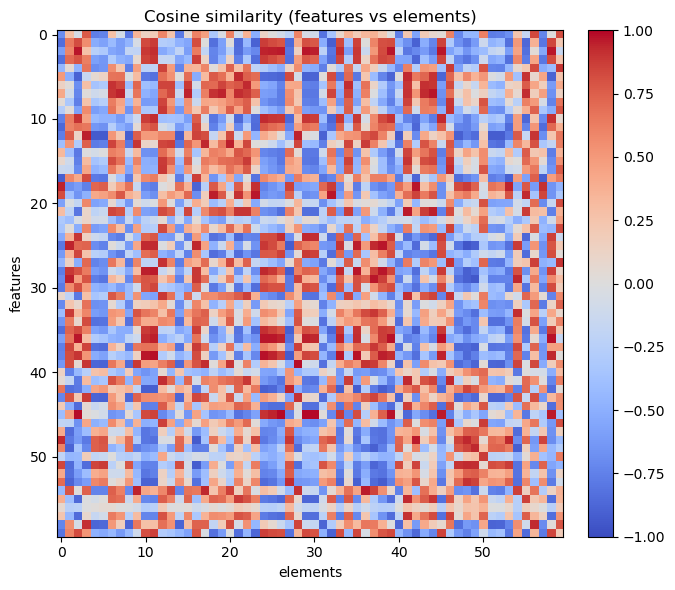

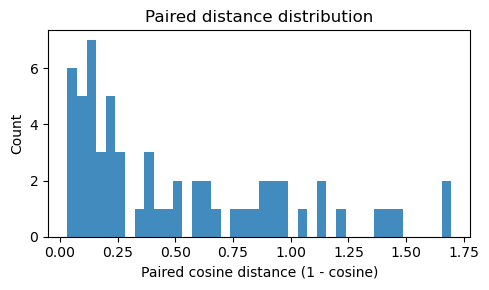

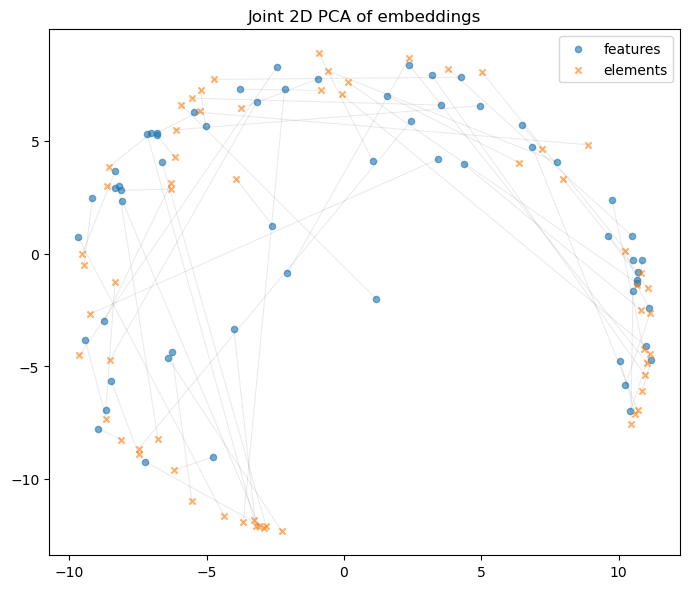

/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


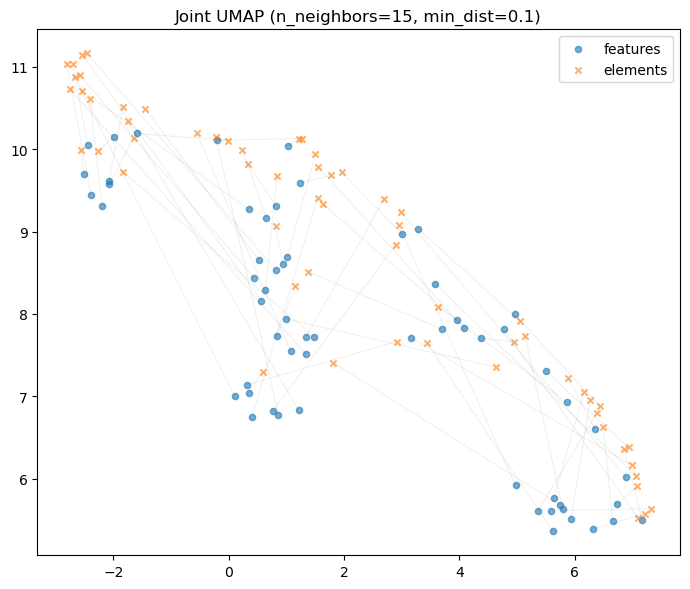

In [49]:
phase_labels = {
    -1: 'not_indexed',
     1: 'Iron bcc (old)',
     3: 'Hematite',
     4: 'Magnetite',
     5: 'Wuestite'
}
e_metrics = evaluate_contrastive(pca_model,features_pc_np,elements_np,loc_test,coord_phase_dict,phase_labels,True)

In [31]:
print("\nTraining cNMF Model...")
cnmf_model, cnmf_train_losses, cnmf_test_losses, final_alignment_cnmf, final_uniformity_cnmf = train_and_evaluate(
    'cnmf', train_data, test_data, output_dim=3,latent_dim=256,num_epochs=200, batch_size=16, lr=3e-4, temperature=1,learnable_temp=True, min_temp=0.01, max_temp=2, temp_anneal=False
)


Training cNMF Model...
Epoch 1: Alignment=0.4323, Uniformity=-0.5527 | ||zf||=1.000 ||ze||=1.000
Epoch [1/200], CNMF - Train Loss: 2.7738, Test Loss: 2.6998, Temp: 1.0000
Epoch [2/200], CNMF - Train Loss: 2.7791, Test Loss: 2.6948, Temp: 1.0020
Epoch [3/200], CNMF - Train Loss: 2.7584, Test Loss: 2.6877, Temp: 1.0037
Epoch [4/200], CNMF - Train Loss: 2.7522, Test Loss: 2.6735, Temp: 1.0034
Epoch [5/200], CNMF - Train Loss: 2.7406, Test Loss: 2.6488, Temp: 1.0023
Epoch [6/200], CNMF - Train Loss: 2.7243, Test Loss: 2.6443, Temp: 1.0010
Epoch [7/200], CNMF - Train Loss: 2.7178, Test Loss: 2.6285, Temp: 1.0011
Epoch [8/200], CNMF - Train Loss: 2.7141, Test Loss: 2.6291, Temp: 0.9995
Epoch [9/200], CNMF - Train Loss: 2.6919, Test Loss: 2.6046, Temp: 0.9991
Epoch [10/200], CNMF - Train Loss: 2.6723, Test Loss: 2.5986, Temp: 0.9977
Epoch 11: Alignment=0.7768, Uniformity=-1.0815 | ||zf||=1.000 ||ze||=1.000
Epoch [11/200], CNMF - Train Loss: 2.6859, Test Loss: 2.6159, Temp: 0.9962
Epoch [12/2

[eval] features zf: shape=(60, 3), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.326810, pairwise-dist(mean)=0.698014
[eval] features zf: approx unique rows (4dp) = 60
[eval] elements ze: shape=(60, 3), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.095299, pairwise-dist(mean)=0.202817
[eval] elements ze: approx unique rows (4dp) = 60
[Retrieval] Top-1/5/10: {1: 0.016666666666666666, 5: 0.1, 10: 0.2} | Median rank: 28.0
[Logit gap] mean/median: -0.17532917857170105 -0.12877845764160156
[Pair cosine distance] mean/std/min/max: 0.7129402756690979 0.381334513425827 0.03262901306152344 1.7382429838180542
[W&I] Alignment=1.4259  Uniformity=-0.8979


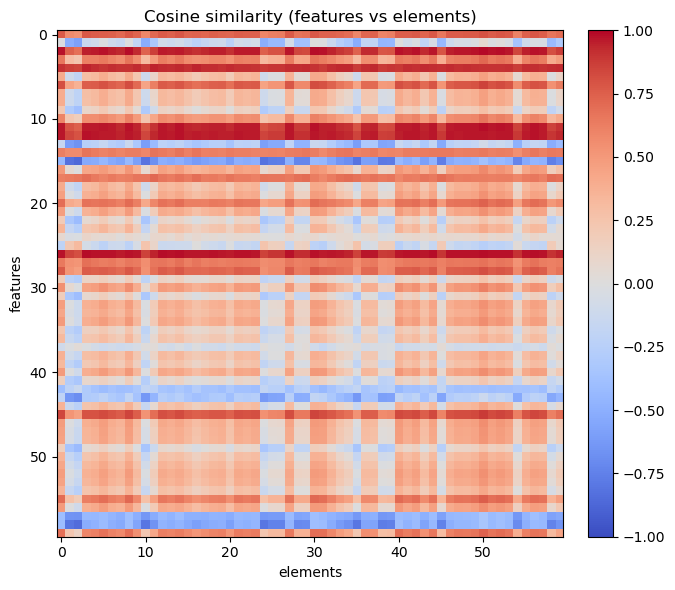

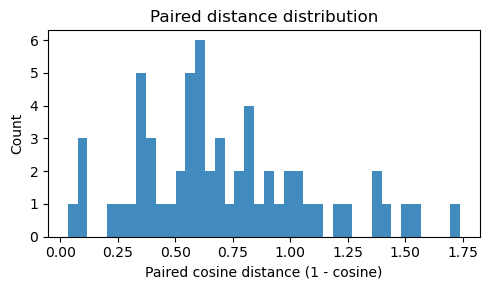

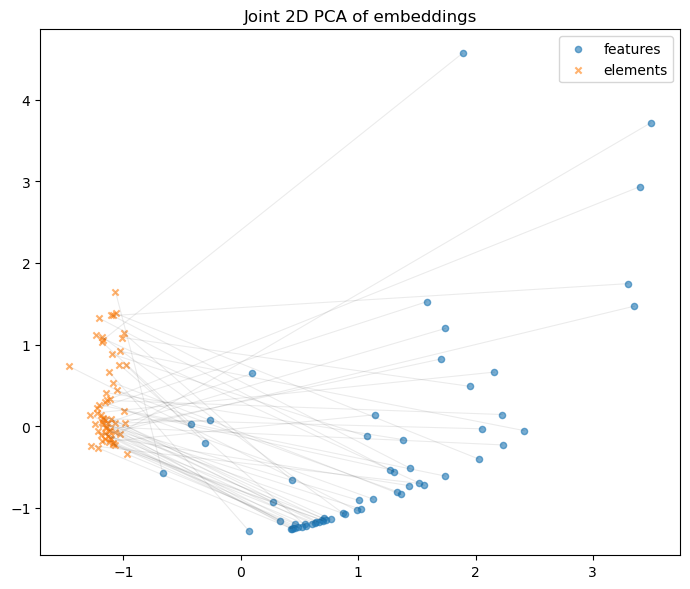

/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


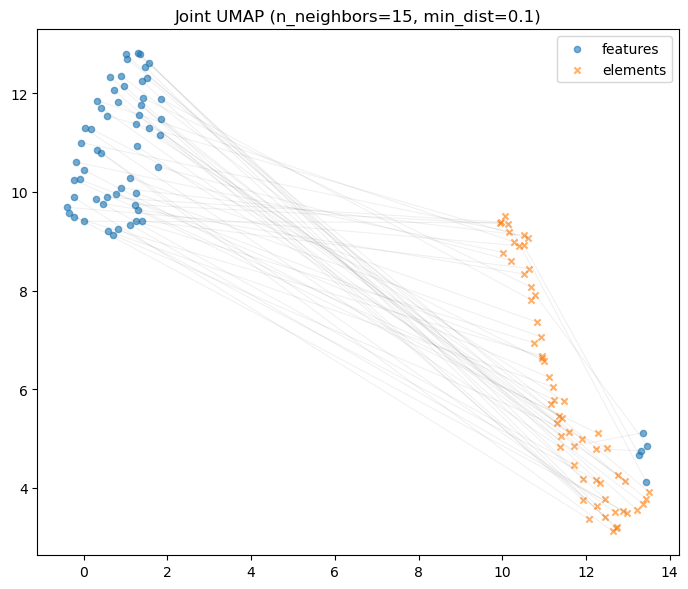

In [32]:
e_metrics = evaluate_contrastive(cnmf_model,features_cnmf_np,elements_np,loc_test,coord_phase_dict,phase_labels,True)